In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import sys
sys.path.insert(0, 'utils/')
from GR_Maze_Utils import *
from GR_RL_Utils import *
import matplotlib.cm as cm
import matplotlib
from matplotlib import rc
rc('text', usetex=False)
matplotlib.rcParams['font.sans-serif'] = ['Arial']


%load_ext autoreload
%autoreload 2

In [2]:
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]

def create_continuous_tree_directed(levels, degree, m = 1): #m = 1 is minimum
    G = nx.DiGraph()
    G.add_nodes_from([('r')])
    index = 0
    for l in range(1,levels+1):
        for i in range(degree**l):
            bin_i = bin(i)[2:].zfill(l)
            ter_i = (''.join([str(k) for k in numberToBase(i,degree)])).zfill(l)
            #print(i,bin_i,ter_i)
            G.add_nodes_from([('r'+ ter_i[::-1])])
            
    corridors_checked = []
    
    for i in range(degree):
        corridors_checked += [('r','r%d'%i)]
        
    for i in list(G.nodes):
        for j in list(G.nodes):
            if len(i) == len(j)+1 and j == i[:len(j)]  and (i,j) not in corridors_checked and (j,i) not in corridors_checked:
                #print(i,j)
                corridors_checked += [(i,j)]
    edges = []
    for e in corridors_checked:
        sorted_ = np.sort([e[0],e[1]])
        curr_level = len(sorted_[0])
        numstates = int(m*(2**(levels-curr_level)))
        #print(curr_level, numstates)
        for im in range(-1,numstates):
            if im == -1:
                nme1 = sorted_[0]
                nme2 = sorted_[0] + ":" + sorted_[1] + ":%d"%(im+1) 
                #convention is upper node:lower node:index. index goes from 0 to numstates - 1
            elif im == numstates-1 :
                nme1 = sorted_[0] + ":" + sorted_[1] + ":%d"%(im)
                nme2 = sorted_[1]
            else:
                nme1 = sorted_[0] + ":" + sorted_[1] + ":%d"%(im)
                nme2 = sorted_[0] + ":" + sorted_[1] + ":%d"%(im+1)
                
            edges += [(nme1,nme2)]
            #print(edges[-1])
                
    G = add_diedges_to_graph(G,edges)
    
    return G

def to_intersection(e):
    return ':' in e[0] and ':' not in e[1]

def from_intersection(e):
    return ':' not in e[0] and ':' in e[1]

def in_corridor(e):
    return ':' in e[0] and ':' in e[1]

def get_transition_matrix_continuous_tree(levels, degree,m=1):
    G = create_continuous_tree_directed(levels, degree)
    index_to_state = get_index_to_state_vec(G)
    S = len(index_to_state)
    A = degree + 1 #if a < degree, go down the ath branch, if a = degree go back up. 
    Tmat = np.zeros((S,A,S)) + 1e-6 #add small constant to avoid dividing by zero downstream. 
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        e = (n1,n2)
        for a in range(A):
            if to_intersection(e):
                if len(n2) == levels + 1 or (len(n2) == 1 and a == degree): 
                    #at the leaf, turn back regardless
                    #or at the root, go back to the previous node if a = degree
                    n3 = deepcopy(n1)
                else:
                    if a == degree: #go up the tree
                        at = deepcopy(n2)
                        to = n2[:-1]
                        sorted_ = np.sort([at,to])
                        curr_level = len(sorted_[0])
                        numstates = m*(2**(levels-curr_level))
                        n3 = to + ":" + at + ":" + "%d"%(numstates-1)
                    else: #go to the ath branch
                        at = deepcopy(n2)
                        to = n2 + str(a)
                        n3 = at + ":" + to + ":" + "0"
                
            elif from_intersection(e):
                if a > 0:
                    n3 = deepcopy(n1)
                else:
                    up,down,ind = n2.split(':')
                    if up == n1:
                        at = up
                        to = down
                    else:
                        at = down
                        to = up
                    
                    sorted_ = np.sort([at,to])
                    curr_level = len(sorted_[0])
                    numstates = m*(2**(levels-curr_level))
                    if up == n1:
                        if int(ind) == numstates - 1:
                            n3 = deepcopy(to)
                        else:
                            n3 = up + ":" + down + ":" + "%d"%(int(ind)+1)
                    else:
                        if int(ind) == 0:
                            n3 = deepcopy(to)
                        else:
                            n3 = up + ":" + down + ":" + "%d"%(int(ind)-1)
                            
                #print(n1,n2,n3,a,at,to)
            elif in_corridor(e):
                if a > 0:
                    n3 = deepcopy(n1)
                else:
                    up,down,ind1 = n1.split(':')
                    up,down,ind2 = n2.split(':')
                    sorted_ = np.sort([up,down])
                    curr_level = len(sorted_[0])
                    numstates = m*(2**(levels-curr_level))
                    #print("hi",n1,n2,up,down,ind1,ind2)
                    if int(ind2) > int(ind1):
                        if int(ind2) == numstates - 1:
                            n3 = deepcopy(down)
                        else:
                            n3 = up + ":" + down + ":" + "%d"%(int(ind2)+1)
                    elif int(ind2) < int(ind1):
                        if int(ind2) == 0:
                            n3 = deepcopy(up)
                        else:
                            n3 = up + ":" + down + ":" + "%d"%(int(ind2)-1)
                
            #print(s,n1,n2,n3,a)
            nextstate = (n2,n3)
            nextstate_index = get_state_index(nextstate,G)
            Tmat[s,a,nextstate_index] = 1
            
    Tmat /= np.sum(Tmat,axis=-1)[:,:,None]
    return Tmat  

def initialize_Q_continuous_tree(G,degree, turn_back = False): #set exploration probabilities via Qe
    index_to_state = get_index_to_state_vec(G)
    
    S = len(index_to_state)
    A = degree + 1
    
    if turn_back:
        qe_back = 0
    else:
        qe_back = -10
    
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        e = (n1,n2)
        
        G[state[0]][state[1]]['Qr'] = np.zeros(A)
        G[state[0]][state[1]]['Qe'] = np.zeros(A)

        if from_intersection(e) or in_corridor(e):
            for a in range(1,degree+1):
                G[state[0]][state[1]]['Qe'][a] = -15
        elif to_intersection(e):
            up,down,ind = n1.split(':')
            if up == n2:
                at = down
                to = up
            else:
                at = up
                to = down
            if len(to) > len(at): #going down, but not at leaf
                if len(to) < levels+1:
                    G[state[0]][state[1]]['Qe'][degree] = qe_back
                elif len(to) == levels+1: 
                    for a in range(1,degree+1):
                        G[state[0]][state[1]]['Qe'][a] = -15
            elif len(to) < len(at): #going up
                G[state[0]][state[1]]['Qe'][int(at[-1])] = qe_back
                if len(to) == 1: #if at root, this action is also zero
                    G[state[0]][state[1]]['Qe'][degree] = -15
                    G[state[0]][state[1]]['Qe'][int(at[-1])] = qe_back
    return G

In [9]:
np.random.seed(0)

alpha = 0.1
gam = 1
m = 1
start = ('r00000','r0000:r00000:0')
goal = ('r1111:r11111:0','r11111')

niter = 1000
nepi = 130
lamb = 0.95
mode = 2
q_mem_size = int(3/(1-lamb))

rew = 5
levels = 5
degree = 2
m = 1
turn_back = True

#generate graph and get Q values
G = create_continuous_tree_directed(levels, degree, m)
Tmat = get_transition_matrix_continuous_tree(levels,degree, m)
G = initialize_Q_continuous_tree(G,degree, turn_back=turn_back)

nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,[start],goal,nepi,niter,0,lamb = lamb, q_mem_size=q_mem_size\
                                                ,renew = False,alpha = alpha,gam=gam,rew = rew,mode=mode)

72


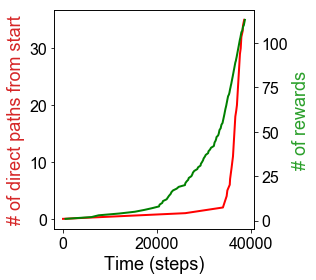

In [10]:
L = len(nx.shortest_path(G,start[0],goal[1]))-1
print(L)
time_paths, cum_paths = get_direct_paths(time_rews,L)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
axis.tick_params(labelsize = 16)
ax = axis.twinx()
ax.plot(time_rews, cum_rews,'g-', lw = 2)
ax.tick_params(labelsize = 16)
axis.plot(time_paths, cum_paths,'r-', lw = 2)
axis.set_ylabel("# of direct paths from start", fontsize= 18, color = 'C3')
ax.set_ylabel("# of rewards", fontsize= 18, color = 'C2')
axis.set_xlabel("Time (steps)", fontsize= 18)
fig.tight_layout()
fig.savefig("./plots/r5_l5_d2_cont_tree_curve.pdf")
plt.show()

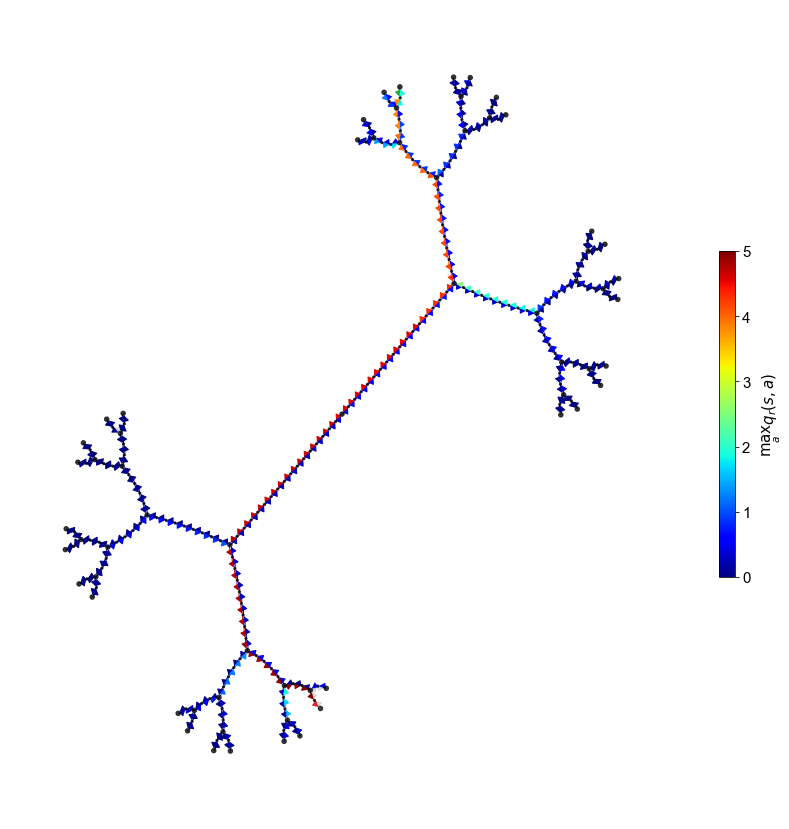

In [11]:
plot_graph_Qr(Gs[-1],vmax = rew, starts = [start], goals = [goal], figsize = (15,15), arrowsize = 12, save_name = "./plots/r5_l5_d2_cont_tree_graph.pdf")

72


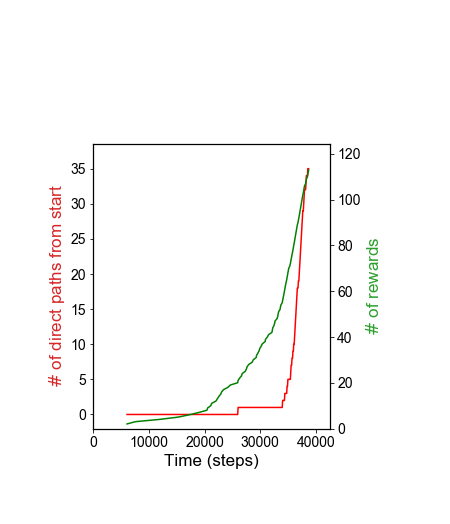

In [12]:
L = len(nx.shortest_path(G,start[0],goal[1]))-1
print(L)
time_paths, cum_paths = get_direct_paths(time_rews,L)

name_prefix = "movie_r%d_l%d_d%d_cont_tree/movie_r%d_l%d_d%d" %(int(rew),levels,degree,int(rew),levels,degree)
create_pngs_for_movie(Gs[:],[start],[goal],time_rews,cum_rews,L,rew, name_prefix, arrowsize=12, figsize = (10,10))

In [ ]:
ffmpeg -framerate 15 -pattern_type glob -i 'movie_r5_l5_d2_curve_*.png' -c:v h264 -pix_fmt yuv420p -allow_sw 1 -vb 20M curve.mp4
ffmpeg -framerate 15 -pattern_type glob -i 'movie_r5_l5_d2_graph_*.png' -c:v h264 -pix_fmt yuv420p -vb 20M graph.mp4
ffmpeg -i graph.mp4 -i curve.mp4 -filter_complex hstack=inputs=2 -vb 20M final.mp4